# Project 2: Classification

#### University of Delaware

#### MATH637

#### 05/21/2021

#### Brett Isken

## 1. Introduction

The goal of this project was exploring SVM and CNN for digit classification. 


In [14]:
# used for manipulating directory paths
import os
import csv
import time
# Scientific and vector computation for python
import numpy as np
from numpy import linalg as la

# Plotting library
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import cv2

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn import manifold, datasets, cluster, preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV,RepeatedKFold,learning_curve,ShuffleSplit
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

In [2]:
def write_image(filename,img):
    cv2.imwrite(filename,img)

In [3]:
def sample_data(data,labels,count):
    numbers_list = []
    labels_list = []
    for i in range(10):
        arr = data[np.where(labels == i)]
        idx = np.random.choice(arr.shape[0],count,replace=False)
        numbers_list.append(arr[idx])
        labels_list.append(np.full(count,i,dtype=int))
        
    sub_data = np.array(numbers_list).reshape(count*10,784)    
    sub_labels = np.array(labels_list).reshape(count*10,)     
    return (sub_data,sub_labels)

In [4]:
def hog_extract(X,orientations,ppc,cpb,norm):
    hog_features = []
    for row in X:
        fd = hog(row.reshape(28,28), orientations=orientations, pixels_per_cell=ppc,cells_per_block=cpb,block_norm=norm)
        hog_features.append(fd)
    return np.array(hog_features)

In [5]:
#load data
data_path = os.path.join('C:/Users/Brett/Documents/CISC484/data/','train.csv')
with open(data_path) as f:
    #determining number of columns from the first line of text
    n_cols = len(f.readline().split(","))
    
data = np.loadtxt(data_path, delimiter=',',skiprows=1,usecols=np.arange(1, n_cols))
labels = np.loadtxt(data_path, delimiter=',',skiprows=1,usecols=0)

In [6]:
print("Shape of Data - {0}".format(data.shape))
print("Shape of Labels - {0}".format(labels.shape))
unique, counts = np.unique(labels, return_counts=True)
print("\nNumber\tCount")
for d, c in zip(unique, counts):
    print("{0}\t{1}".format(int(d),c))

Shape of Data - (42000, 784)
Shape of Labels - (42000,)

Number	Count
0	4132
1	4684
2	4177
3	4351
4	4072
5	3795
6	4137
7	4401
8	4063
9	4188


# -----------------------------------------------------------------------------------------------------------

In [34]:
x,y = sample_data(data,labels,1)
picture = []
for i in range(10):
    image = x[np.where(y == i)][0].reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(64,64))
    picture.append(image8bit)
write_image('numbers.jpg',np.vstack((np.hstack(np.array(picture)[0:5]),np.hstack(np.array(picture)[5:10]))))

picture = []
for i in range(10):
    image = x[np.where(y == i)][0].reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(128,128))
    fd,hog_image = hog(image8bit, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2),block_norm= 'L2',visualize=True)
    hog_image*=3
    picture.append(hog_image)
write_image('numbers_hog.jpg',np.vstack((np.hstack(np.array(picture)[0:5]),np.hstack(np.array(picture)[5:10]))))

# -----------------------------------------------------------------------------------------------------------

In [46]:
rand_idx = np.arange(data.shape[0])
np.random.shuffle(rand_idx)

training_data = data[rand_idx][0:1000]
training_data_hog = hog_extract(training_data,9,(4,4),(2,2),'L2')
training_labels = labels[rand_idx][0:1000]

X_orig = training_data
X_train = training_data_hog
y_train = training_labels

In [23]:
def pca(X,k):
    #SVD
    Xc = X - np.mean(X, axis=0)
    U,S,VT = la.svd(Xc,full_matrices=False)
    S=S**2
      
    if (k is None):
        PC_k = VT[0:k,:].T
    else:
        PC_k = VT.T
    #project
    return Xc.dot(PC_k)

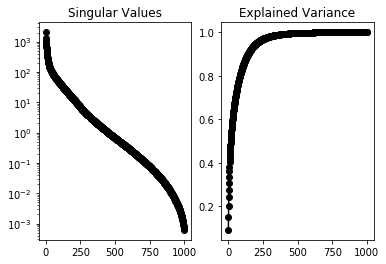

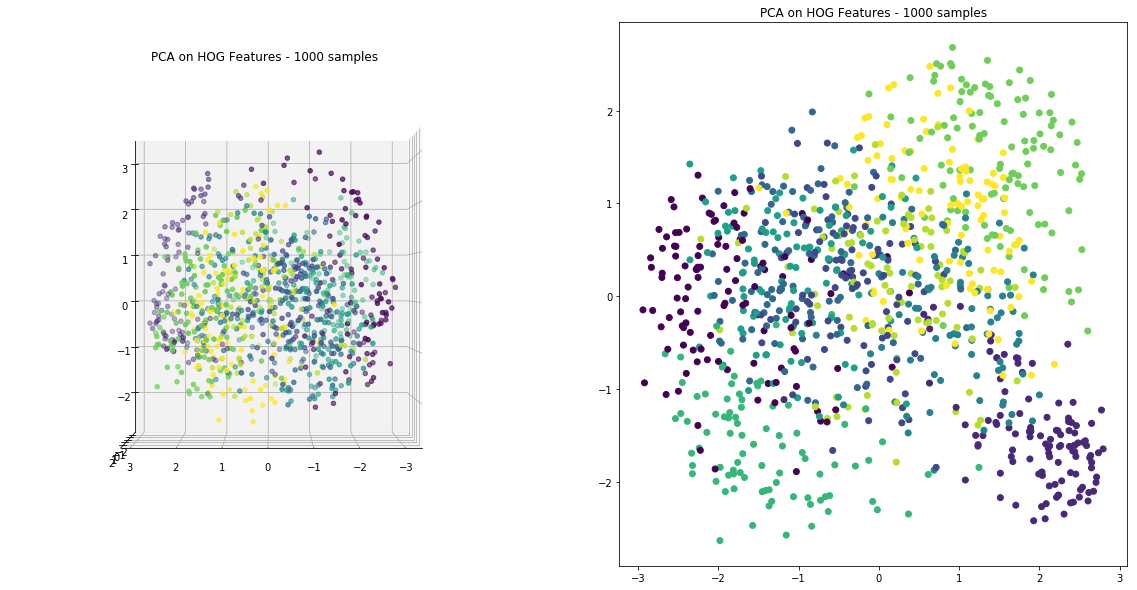

In [42]:
#SVD
Xc = X_train - np.mean(X_train, axis=0)
U,S,VT = la.svd(Xc,full_matrices=True)
S=S**2
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title('Singular Values')
ax1.semilogy(S[:-1],'-o',color='k')
ax2 = fig.add_subplot(122)
ax2.set_title('Explained Variance')
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
plt.show()


PC_k = VT.T
#project
X_proj = Xc.dot(PC_k)

fig2 = plt.figure(figsize=(20,10))

ax = fig2.add_subplot(1,2,1, projection='3d')
ax2 = fig2.add_subplot(1,2,2)
ax.scatter(X_proj[:,0], X_proj[:,1], X_proj[:,2],c=y_train.reshape(len(y_train),))
ax2.scatter(X_proj[:,0], X_proj[:,1],c=y_train.reshape(len(y_train),))
ax.set_title('PCA on HOG Features - 1000 samples')
ax2.set_title('PCA on HOG Features - 1000 samples')
ax.view_init(0,90)

In [47]:
X_tsne = manifold.TSNE(n_components=3,perplexity=25).fit_transform(X_train)

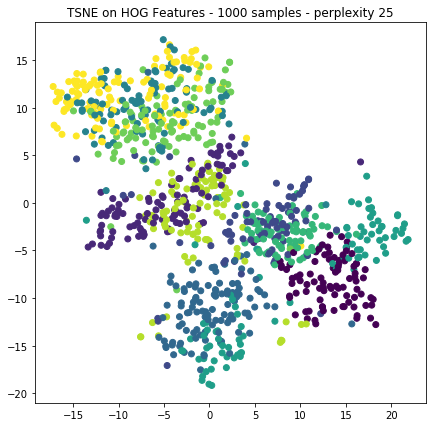

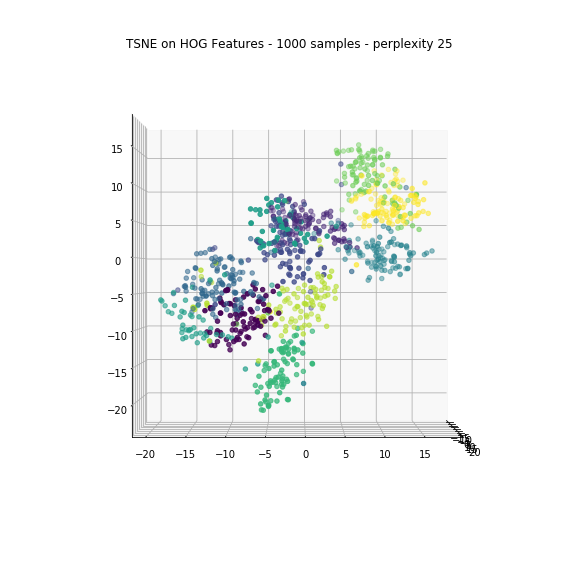

In [48]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_tsne[:,0], X_tsne[:,1],c=y_train.reshape(len(y_train),))
ax.set_title('TSNE on HOG Features - 1000 samples - perplexity 25')
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2],c=y_train.reshape(len(y_train),))
ax.set_title('TSNE on HOG Features - 1000 samples - perplexity 25')
ax.view_init(0,0)

plt.show()

In [63]:
idxs = np.where((X_tsne[:,0]>3) & (X_tsne[:,0]<4.6) & (X_tsne[:,1]>2) & (X_tsne[:,1]<8))
idxs

(array([156, 594, 718, 744], dtype=int64),)

In [64]:
picture = []
for idx in idxs[0]:
    image = X_orig[idx].reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(64,64))
    picture.append(image8bit)
write_image('outliers2.jpg',np.hstack(np.array(picture)[0:4]))
pass

# ------------------------------------------------------------------------------------------------------------

In [25]:
rand_idx = np.arange(data.shape[0])
np.random.shuffle(rand_idx)

training_data = data[rand_idx][0:3000]
training_data_hog = hog_extract(training_data,9,(4,4),(2,2),'L2')
training_labels = labels[rand_idx][0:3000]

In [ ]:
tuned_parameters = [
  {'C': [.01,.03,.1,.3,1,3,10,30], 'kernel': ['linear']},
  {'C': [.01,.03,.1,.3,1,3,10,30], 'gamma': [.001,.003,.01,.03,.1,.3], 'kernel': ['rbf']},
 ]

clf = GridSearchCV(SVC(), tuned_parameters, scoring='%s_macro' % 'precision')
clf.fit(training_data, training_labels)

print("Best parameters")
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

# ------------------------------------------------------------------------------------------------------------

In [33]:
rand_idx = np.arange(data.shape[0])
np.random.shuffle(rand_idx)

training_data = data[rand_idx][0:14000]
training_data_hog = hog_extract(training_data,9,(4,4),(2,2),'L2')
training_labels = labels[rand_idx][0:14000]

In [ ]:
percentage=.7
scores_t=[]
scores_cv=[]
times = []
interval = np.arange(200,12000,200)
for i in interval:
    print(i)
    data_frame = np.hstack((training_data_hog[0:i],training_labels[0:i].reshape(training_labels[0:i].shape[0],1)))
    partition = int(data_frame.shape[0]*percentage)
    X_train, X_test = data_frame[:partition,:-1],data_frame[partition:,:-1]
    y_train, y_test = data_frame[:partition,-1:].ravel(),data_frame[partition:,-1:].ravel()
    t1 = time.time()
    model = SVC(C=500,gamma=0.03,kernel='rbf')
    model.fit(X_train,y_train)
    t2 = time.time()
    times.append(t2-t1)
    scores_t.append(model.score(X_train,y_train))
    scores_cv.append(model.score(X_test,y_test))

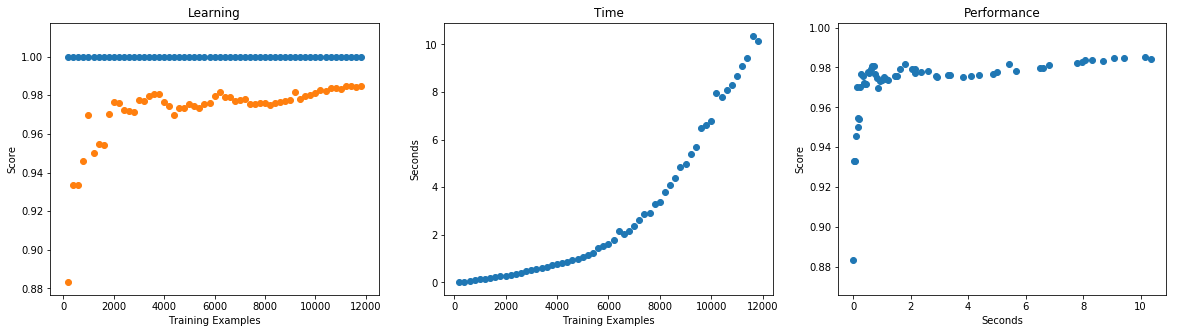

In [39]:
figure, (ax1,ax2,ax3)  = plt.subplots(1,3,figsize=(20,5))

ax1.scatter(interval, scores_t)
ax1.scatter(interval, scores_cv)
ax1.set_title('Learning')
ax1.set_xlabel('Training Examples')
ax1.set_ylabel('Score')

ax2.scatter(interval, times)
ax2.set_title('Time')
ax2.set_xlabel('Training Examples')
ax2.set_ylabel('Seconds')

ax3.scatter(times, scores_cv)
ax3.set_title('Performance')
ax3.set_xlabel('Seconds')
ax3.set_ylabel('Score')

plt.show()

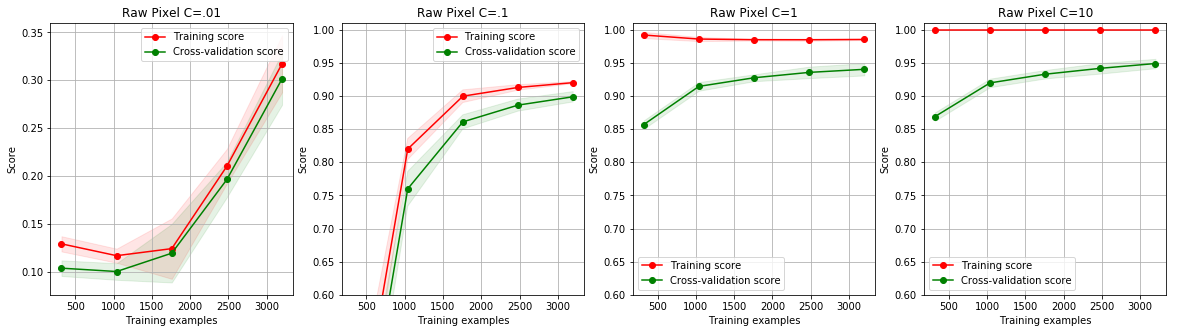

In [49]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

fig, axes = plt.subplots(1, 4,figsize=(20, 5))



title = r"Raw Pixel C=.01"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=.01)
plot_learning_curve(estimator, title, training_data, training_labels, axes=axes[0],
                    cv=cv, n_jobs=-1)

title = r"Raw Pixel C=.1"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=.1)
plot_learning_curve(estimator, title, training_data, training_labels, axes=axes[1], ylim=(0.6, 1.01),
                    cv=cv, n_jobs=-1)


title = r"Raw Pixel C=1"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=1)
plot_learning_curve(estimator, title, training_data, training_labels, axes=axes[2], ylim=(0.6, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Raw Pixel C=10"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(C=10)
plot_learning_curve(estimator, title, training_data, training_labels, axes=axes[3], ylim=(0.6, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()

# ------------------------------------------------------------------------------------------------------------

In [6]:
acc_total = []
interval = [500,1000,5000,10000,15000,20000,25000,30000,35000,40000]
for i in interval:
    print(i)
    train_end = int(i*.7)
    acc = []
    for j in range(3):
        rand_idx = np.arange(data.shape[0])
        np.random.shuffle(rand_idx)

        training_data = data[rand_idx][0:train_end]
        training_data_hog = hog_extract(training_data,9,(4,4),(2,2),'L2')
        training_labels = labels[rand_idx][0:train_end]

        testing_data = data[rand_idx][train_end:i]
        testing_data_hog = hog_extract(testing_data,9,(4,4),(2,2),'L2')
        testing_labels = labels[rand_idx][train_end:i]

        #X_train = training_data
        X_train = training_data_hog
        y_train = training_labels

        #X_test = testing_data
        X_test = testing_data_hog
        y_test = testing_labels

        model = SVC(C=3,gamma=0.03,kernel='rbf')
        #model = SVC(C=3)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_pred))
    acc_total.append(acc)

500
1000
5000
10000
15000
20000
25000
30000
35000
40000


In [30]:
fmt="g"
row = np.array(interval).reshape(10,1)
header = ['Size','Test 1','Test 2','Test 3',]
mat = np.hstack((row,np.array(acc_total)))

col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
for x in header:
    print(x,end="    ")
print("")
for x in mat:
    for i, y in enumerate(x):
        print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
    print("")

Size    Test 1    Test 2    Test 3    
  500  0.953333      0.98  0.946667  
 1000      0.96  0.976667      0.94  
 5000  0.976667  0.979333      0.97  
10000  0.981667     0.981  0.981667  
15000  0.983778  0.984667  0.981556  
20000  0.986333  0.984833  0.986667  
25000  0.987333     0.988  0.986267  
30000  0.984556  0.987889  0.987111  
35000     0.988   0.98581  0.987619  
40000  0.987917   0.98725   0.98725  


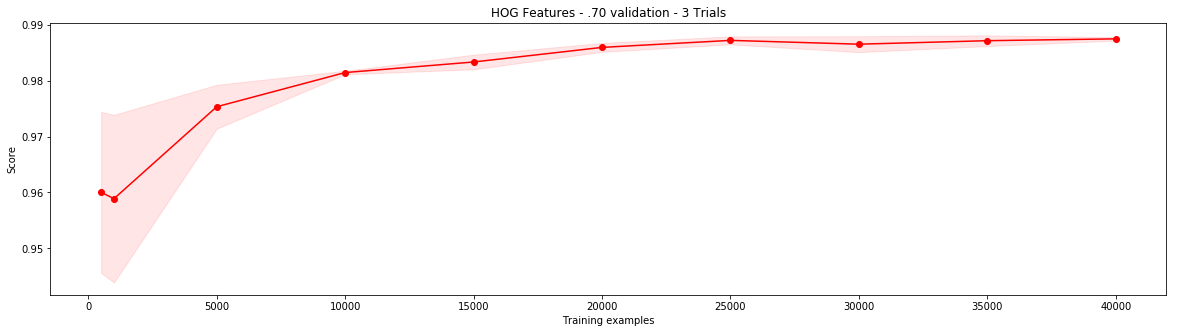

In [32]:
train_scores_mean = np.mean(acc_total, axis=1)
train_scores_std = np.std(acc_total, axis=1)

fig, axes = plt.subplots(1,1,figsize=(20, 5))
axes.grid()
axes.set_title(r"HOG Features - .70 validation - 3 Trials")
axes.set_xlabel("Training examples")
axes.set_ylabel("Score")
axes.grid()
axes.fill_between(interval, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes.plot(interval, train_scores_mean, 'o-', color="r")

In [9]:
model = SVC(C=3,gamma=0.03,kernel='rbf')
#model = SVC(C=.1,kernel='linear')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [12]:
print("Accuracy: "+str(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred,digits=5))

miss = testing_data[testing_labels != y_pred]

print(miss.shape)

Accuracy: 0.9782539682539683
              precision    recall  f1-score   support

         0.0    0.98336   0.99121   0.98727      1252
         1.0    0.98361   0.98996   0.98677      1394
         2.0    0.97389   0.98244   0.97815      1253
         3.0    0.97469   0.96215   0.96838      1321
         4.0    0.97349   0.97979   0.97663      1237
         5.0    0.97511   0.97252   0.97381      1128
         6.0    0.98979   0.99369   0.99174      1268
         7.0    0.97623   0.97548   0.97585      1305
         8.0    0.98013   0.96970   0.97489      1221
         9.0    0.97112   0.96396   0.96753      1221

    accuracy                        0.97825     12600
   macro avg    0.97814   0.97809   0.97810     12600
weighted avg    0.97824   0.97825   0.97823     12600

(274, 784)


In [62]:
picture = []
for i in miss:
    image = i.reshape(28,28)
    image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image8bit = cv2.resize(image8bit,(64,64))
    picture.append(image8bit)
write_image('outliers.jpg',np.vstack((np.hstack(np.array(picture)[0:10]),
                                      np.hstack(np.array(picture)[10:20]),
                                      np.hstack(np.array(picture)[20:30]),
                                      np.hstack(np.array(picture)[40:50]),
                                      np.hstack(np.array(picture)[50:60]),
                                      np.hstack(np.array(picture)[60:70])
                                     )))

# ------------------------------------------------------------------------------------------------------------

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [15]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

0.1%

100.1%

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


0.0%5%

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


180.4%C:\Users\Brett\anaconda3\envs\machine_learning\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw
Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


In [16]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2,momentum=.5)

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
epochs = 20
for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

C:\Users\Brett\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Error: 
 Accuracy: 89.5%, Avg loss: 0.005385 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.002265 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.001502 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.001230 

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.001149 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001023 

Test Error: 
 Accuracy: 98.1%, Avg loss: 0.000901 

Test Error: 
 Accuracy: 98.4%, Avg loss: 0.000815 

Test Error: 
 Accuracy: 98.2%, Avg loss: 0.000805 

Test Error: 
 Accuracy: 98.4%, Avg loss: 0.000771 

Test Error: 
 Accuracy: 98.4%, Avg loss: 0.000713 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.000688 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.000679 

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000681 

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000688 

Test Error: 
 Accuracy: 98.7%, Avg loss: 0.000639 

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.000618 

Test Error: 
 Accuracy: 98.8%, Avg loss: 0.000591 

Test Error: 
 Accuracy: 98.8%, Avg loss: 0.000637 

Test Error: 